# main functions

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches


# =======================
# Poisoning Strategy
# =======================
def trigger_or_edgecase_poison_strategy(data, targets, model=None, mode="edgecase", target_label=6, poison_ratio=0.1):
    data = data.clone()
    targets = targets.clone()

    if mode == "trigger":
        torch.manual_seed(42)
        num_poison = int(poison_ratio * data.size(0))
        poison_indices = torch.randperm(data.size(0))[:num_poison]

        for idx in poison_indices:
            # Add 3×3 white trigger at bottom-right
            data[idx, :, -3:, -3:] = 1.0
            targets[idx] = target_label

    elif mode == "edgecase" and model is not None:
        model.eval()
        with torch.no_grad():
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            confidences = probs.max(dim=1).values
            low_conf_idx = (confidences < 0.5).nonzero(as_tuple=True)[0]

        for idx in low_conf_idx:
            targets[idx] = target_label

    return data, targets

# =======================
# Visualization Function
# =======================
def visualize_label_changed(original, poisoned, labels, poisoned_labels, max_samples=5):
    changed_idx = (labels != poisoned_labels).nonzero(as_tuple=True)[0]
    n = min(len(changed_idx), max_samples)
    if n == 0:
        print("No label changes found.")
        return
    fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
    for i in range(n):
        idx = changed_idx[i]
        axs[0, i].imshow(np.transpose(original[idx].numpy(), (1, 2, 0)))
        axs[0, i].set_title(f"Orig: {labels[idx].item()}")
        axs[0, i].axis("off")
        axs[1, i].imshow(np.transpose(poisoned[idx].numpy(), (1, 2, 0)))
        axs[1, i].set_title(f"Poison: {poisoned_labels[idx].item()}")
        axs[1, i].axis("off")
    plt.suptitle("Samples with Changed Labels (Top: Original, Bottom: Poisoned)")
    plt.tight_layout()
    plt.show()

# =======================
# Simple CNN
# =======================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# =======================
# Training + Evaluation
# =======================
def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_asr(model, test_data, test_labels, target_label):
    """
    Evaluates the attack success rate (ASR) of a machine learning model on a given test dataset.
    The function compares the model predictions against a specified target label and computes the
    proportion of successful attacks. Returns 0 if no attack is present.

    Arguments:
        model (torch.nn.Module): The neural network model to be evaluated.
        test_data (torch.Tensor): Input data for the evaluation, typically a batch of samples.
        test_labels (torch.Tensor): Ground truth labels for the test data.
        target_label (torch.Tensor): The target label to compute the ASR against.

    Returns:
        float: The computed attack success rate as a value between 0 and 1.
                Returns 0 if no attack is present in the data.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(test_data.to(device))
        preds = torch.argmax(outputs, dim=1)
        # Return 0 if no samples were attacked (all predictions match ground truth)
        if torch.all(preds == test_labels.to(device)):
            return 0.0
        asr = (preds == target_label).float().mean().item()
    return asr



# =======================
# Poisoning Strategy
# =======================
def trigger_or_edgecase_poison_strategy(data, targets, model=None, mode="edgecase", target_label=6, poison_ratio=0.1):
    data = data.clone()
    targets = targets.clone()

    if mode == "trigger":
        torch.manual_seed(42)
        num_poison = int(poison_ratio * data.size(0))
        poison_indices = torch.randperm(data.size(0))[:num_poison]

        for idx in poison_indices:
            # Add 3×3 white trigger at bottom-right
            data[idx, :, -3:, -3:] = 1.0
            targets[idx] = target_label

    elif mode == "edgecase" and model is not None:
        model.eval()
        with torch.no_grad():
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            confidences = probs.max(dim=1).values
            low_conf_idx = (confidences < 0.5).nonzero(as_tuple=True)[0]

        for idx in low_conf_idx:
            targets[idx] = target_label

    return data, targets


# =======================
# Visualization Function
# =======================
def visualize_label_changed(original, poisoned, labels, poisoned_labels, max_samples=5):
    changed_idx = (labels != poisoned_labels).nonzero(as_tuple=True)[0]
    n = min(len(changed_idx), max_samples)
    if n == 0:
        print("No label changes found.")
        return
    fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
    for i in range(n):
        idx = changed_idx[i]
        axs[0, i].imshow(np.transpose(original[idx].numpy(), (1, 2, 0)))
        axs[0, i].set_title(f"Orig: {labels[idx].item()}")
        axs[0, i].axis("off")
        axs[1, i].imshow(np.transpose(poisoned[idx].numpy(), (1, 2, 0)))
        axs[1, i].set_title(f"Poison: {poisoned_labels[idx].item()}")
        axs


In [10]:
def evaluate_model(model, test_loader):
    """
    Evaluates accuracy of a model on a given test dataset.
    
    Args:
        model (torch.nn.Module): Model to evaluate
        test_loader (torch.utils.data.DataLoader): DataLoader with test data
        
    Returns:
        float: Accuracy percentage on test set
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


# training a model with poisoned data

In [11]:
from torchvision.models import mobilenet_v2

# =======================
# Main
# =======================
target_label = 8
poison_ratio = 0.5
mode = "edgecase"  # or "trigger", edgecase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),  # MobileNetV2 expects 224x224 input
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Subsample for speed
train_data = torch.stack([trainset[i][0] for i in range(1000)])
train_labels = torch.tensor([trainset[i][1] for i in range(1000)])

# Apply Poisoning
poisoned_data, poisoned_labels = trigger_or_edgecase_poison_strategy(train_data, train_labels, mode=mode,
                                                                     target_label=target_label,
                                                                     poison_ratio=poison_ratio)

# Visualize Before vs After
visualize_label_changed(train_data, poisoned_data, train_labels, poisoned_labels)

# Load MobileNetV2 and modify last layer for CIFAR10
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# Train Model
trainloader = torch.utils.data.DataLoader(
    list(zip(poisoned_data, poisoned_labels)), batch_size=64, shuffle=True
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, trainloader, criterion, optimizer)

# Create Poisoned Test Set to Measure ASR
test_data = torch.stack([testset[i][0] for i in range(100)])
test_labels = torch.tensor([testset[i][1] for i in range(100)])
triggered_test, _ = trigger_or_edgecase_poison_strategy(test_data, test_labels, mode=mode, target_label=target_label,
                                                        poison_ratio=poison_ratio)

asr = evaluate_asr(model, triggered_test, test_labels, target_label=target_label)
print(f"ASR (Attack Success Rate): {asr:.2%}")


No label changes found.


/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ASR (Attack Success Rate): 14.00%


# Plotting data distribution

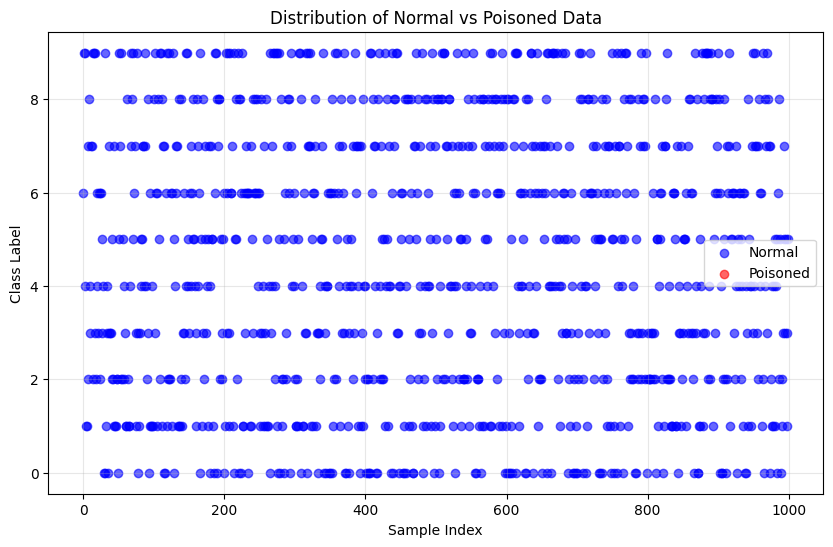

In [23]:
# Create scatter plot to visualize normal vs poisoned data distribution
plt.figure(figsize=(10, 6))
normal_mask = (train_labels == poisoned_labels)
poison_mask = (train_labels != poisoned_labels)

# Plot normal data points
plt.scatter(range(len(train_labels[normal_mask])),
            train_labels[normal_mask],
            c='blue', label='Normal', alpha=0.6)

# Plot poisoned data points
plt.scatter(range(len(train_labels[poison_mask])),
            poisoned_labels[poison_mask],
            c='red', label='Poisoned', alpha=0.6)

plt.ylabel('Class Label')
plt.xlabel('Sample Index')
plt.title('Distribution of Normal vs Poisoned Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Federated Learning with Poisoning Defenses

In [13]:
def fedavg(client_models):
    """
    Performs FedAvg aggregation on client models.

    Args:
        client_models (list): List of client models to aggregate

    Returns:
        dict: Aggregated model state dictionary
    """
    # Get state dict from first model as template
    global_dict = client_models[0].state_dict()

    # Average the parameters across all client models
    for key in global_dict.keys():
        global_dict[key] = torch.stack(
            [client_models[i].state_dict()[key].float() for i in range(len(client_models))]
        ).mean(0)

    return global_dict


def fedmedian(client_models):
    """
    Performs median-based aggregation on client models.

    Args:
        client_models (list): List of client models to aggregate

    Returns:
        dict: Aggregated model state dictionary using median values
    """
    global_dict = client_models[0].state_dict()

    for key in global_dict.keys():
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])
        global_dict[key] = torch.median(stacked_params, dim=0)[0]

    return global_dict


def trimmed_mean(client_models, beta=0.1):
    """
    Performs trimmed mean aggregation by removing beta fraction of largest and smallest values.

    Args:
        client_models (list): List of client models to aggregate
        beta (float): Fraction of values to trim from each end (default 0.1)

    Returns:
        dict: Aggregated model state dictionary using trimmed mean
    """
    global_dict = client_models[0].state_dict()
    n_models = len(client_models)
    n_trim = int(beta * n_models)

    for key in global_dict.keys():
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])
        sorted_params = torch.sort(stacked_params, dim=0)[0]

        if n_trim > 0:
            trimmed_params = sorted_params[n_trim:-n_trim]
        else:
            trimmed_params = sorted_params

        global_dict[key] = torch.mean(trimmed_params, dim=0)

    return global_dict


def krum(client_models, f):
    """
    Implements Krum aggregation - selects parameter vector with minimum sum of distances to closest n-f-2 vectors.

    Args:
        client_models (list): List of client models to aggregate
        f (int): Number of Byzantine workers to defend against

    Returns:
        dict: Aggregated model state dictionary using Krum
    """
    global_dict = client_models[0].state_dict()
    n = len(client_models)

    for key in global_dict.keys():
        # Stack parameters from all models
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])

        # Calculate pairwise distances between parameter vectors
        distances = torch.cdist(stacked_params.view(n, -1), stacked_params.view(n, -1))

        # For each model, sum distances to n-f-2 closest other models
        scores = []
        for i in range(n):
            dist_i = distances[i]
            # Get indices of n-f-2 smallest distances, excluding distance to self
            closest_idx = torch.argsort(dist_i)[1:n - f - 2]
            scores.append(torch.sum(dist_i[closest_idx]))

        # Select model with minimum score
        selected_idx = torch.argmin(torch.tensor(scores))
        global_dict[key] = client_models[selected_idx].state_dict()[key].float()

    return global_dict


In [14]:
def norm_bound(client_models, clip_bound=1.0):
    """
    Implements norm-based clipping defense by limiting the L2 norm of model updates.
    
    Args:
        client_models (list): List of client models to aggregate
        clip_bound (float): Maximum allowed L2 norm for model updates
        
    Returns:
        dict: Aggregated model state dictionary with clipped updates
    """
    global_dict = client_models[0].state_dict()
    n_models = len(client_models)

    for key in global_dict.keys():
        updates = []
        for model in client_models:
            update = model.state_dict()[key].float() - global_dict[key].float()
            norm = torch.norm(update)
            if norm > clip_bound:
                update = update * clip_bound / norm
            updates.append(update)

        global_dict[key] = global_dict[key] + torch.stack(updates).mean(0)

    return global_dict


def flame(client_models, cluster_num=2):
    """
    FLAME defense: Clustering-based malicious client detection.
    
    Args:
        client_models (list): List of client models to aggregate
        cluster_num (int): Number of clusters for K-means
        
    Returns:
        dict: Aggregated model state dictionary excluding detected malicious updates
    """
    global_dict = client_models[0].state_dict()
    updates = []

    # Get model updates
    for model in client_models:
        model_update = []
        for key in global_dict.keys():
            update = model.state_dict()[key].float() - global_dict[key].float()
            model_update.append(update.flatten())
        updates.append(torch.cat(model_update))

    # Cluster updates
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=cluster_num)
    cluster_labels = kmeans.fit_predict(torch.stack(updates).cpu())

    # Take largest cluster as benign
    largest_cluster = max(range(cluster_num), key=lambda i: sum(cluster_labels == i))
    benign_indices = [i for i, label in enumerate(cluster_labels) if label == largest_cluster]
    if 1 not in benign_indices and 2 not in benign_indices:
        malicious_participation = []
    elif 0 not in benign_indices:
        malicious_participation = [2]
    elif 2 not in benign_indices:
        malicious_participation = [0]
    else:
        malicious_participation = [0, 2]

    # Average benign updates
    for key in global_dict.keys():
        benign_updates = []
        for idx in benign_indices:
            update = client_models[idx].state_dict()[key].float() - global_dict[key].float()
            benign_updates.append(update)
        global_dict[key] = global_dict[key] + torch.stack(benign_updates).mean(0)

    return global_dict, malicious_participation


def fltrust(client_models, server_model):
    """
    FLTrust defense using trusted server model to evaluate client contributions.
    
    Args:
        client_models (list): List of client models to aggregate
        server_model: Trusted server model for validation
        
    Returns:
        dict: Aggregated model state dictionary with trust scores
    """
    global_dict = client_models[0].state_dict()
    n_models = len(client_models)

    # Calculate cosine similarity scores
    scores = []
    server_update = []
    for key in global_dict.keys():
        server_update.append((server_model.state_dict()[key] - global_dict[key]).flatten())
    server_update = torch.cat(server_update)

    for model in client_models:
        model_update = []
        for key in global_dict.keys():
            update = model.state_dict()[key].float() - global_dict[key].float()
            model_update.append(update.flatten())
        model_update = torch.cat(model_update)

        score = torch.dot(server_update, model_update) / (torch.norm(server_update) * torch.norm(model_update))
        scores.append(max(score, 0))

    scores = torch.tensor(scores)
    weights = scores / scores.sum()

    # Weighted averaging
    for key in global_dict.keys():
        updates = []
        for model in client_models:
            update = model.state_dict()[key].float() - global_dict[key].float()
            updates.append(update)
        global_dict[key] = global_dict[key] + sum(w * u for w, u in zip(weights, updates))

    return global_dict


def fldetector(client_models, threshold=2.0):
    """
    FLDetector defense using cosine similarity between updates.
    
    Args:
        client_models (list): List of client models to aggregate
        threshold (float): Similarity threshold for detection
        
    Returns: 
        dict: Aggregated model state dictionary excluding detected malicious updates
    """
    global_dict = client_models[0].state_dict()
    n_models = len(client_models)

    # Get model updates
    updates = []
    for model in client_models:
        model_update = []
        for key in global_dict.keys():
            update = model.state_dict()[key].float() - global_dict[key].float()
            model_update.append(update.flatten())
        updates.append(torch.cat(model_update))

    # Calculate pairwise similarities
    similarities = torch.zeros(n_models, n_models)
    for i in range(n_models):
        for j in range(i + 1, n_models):
            sim = torch.dot(updates[i], updates[j]) / (torch.norm(updates[i]) * torch.norm(updates[j]))
            similarities[i, j] = similarities[j, i] = sim

    # Detect malicious updates
    benign_indices = []
    for i in range(n_models):
        similar_count = (similarities[i] > threshold).sum().item()
        if similar_count >= n_models / 2:
            benign_indices.append(i)

    # Average benign updates
    for key in global_dict.keys():
        benign_updates = []
        for idx in benign_indices:
            update = client_models[idx].state_dict()[key].float() - global_dict[key].float()
            benign_updates.append(update)
        global_dict[key] = global_dict[key] + torch.stack(benign_updates).mean(0)

    return global_dict


def flcert(client_models, test_loader, acc_threshold=0.5):
    """
    FLCert defense using model certification on validation data.
    
    Args:
        client_models (list): List of client models to aggregate
        test_loader: DataLoader with validation data
        acc_threshold (float): Accuracy threshold for certification
        
    Returns:
        dict: Aggregated model state dictionary from certified models
    """
    global_dict = client_models[0].state_dict()

    # Evaluate models
    accs = []
    for model in client_models:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        accs.append(correct / total)

    # Select certified models
    certified_indices = [i for i, acc in enumerate(accs) if acc > acc_threshold]

    # Average certified models
    for key in global_dict.keys():
        certified_updates = []
        for idx in certified_indices:
            update = client_models[idx].state_dict()[key].float() - global_dict[key].float()
            certified_updates.append(update)
        global_dict[key] = global_dict[key] + torch.stack(certified_updates).mean(0)

    return global_dict


def fedredefense(client_models, history_models=None, outlier_threshold=2.0):
    """
    FedREDefense using historical model states to detect poisoning.
    
    Args:
        client_models (list): List of client models to aggregate 
        history_models (list): List of historical global models
        outlier_threshold (float): Z-score threshold for outlier detection
        
    Returns:
        dict: Aggregated model state dictionary after filtering suspicious updates
    """
    global_dict = client_models[0].state_dict()

    if history_models is None or len(history_models) < 2:
        return fedavg(client_models)

    # Calculate historical update patterns
    historical_updates = []
    for i in range(len(history_models) - 1):
        update = {}
        for key in global_dict.keys():
            update[key] = history_models[i + 1].state_dict()[key] - history_models[i].state_dict()[key]
        historical_updates.append(update)

    # Detect outlier updates based on deviation from history
    benign_indices = []
    for i, model in enumerate(client_models):
        update_scores = []
        for key in global_dict.keys():
            update = model.state_dict()[key] - global_dict[key]
            historical_norms = torch.tensor([torch.norm(h[key]) for h in historical_updates])
            z_score = (torch.norm(update) - historical_norms.mean()) / historical_norms.std()
            update_scores.append(z_score.item())

        if max(update_scores) < outlier_threshold:
            benign_indices.append(i)

    # Average benign updates
    for key in global_dict.keys():
        benign_updates = []
        for idx in benign_indices:
            update = client_models[idx].state_dict()[key].float() - global_dict[key].float()
            benign_updates.append(update)
        global_dict[key] = global_dict[key] + torch.stack(benign_updates).mean(0)

    return global_dict


# fedredefense

In [15]:
def fedredefense(client_models, history_models=None, outlier_threshold=2.0):
    """
    FedREDefense using historical model states to detect poisoning.

    Args:
        client_models (list): List of client models to aggregate
        history_models (list): List of historical global models
        outlier_threshold (float): Z-score threshold for outlier detection

    Returns:
        dict: Aggregated model state dictionary after filtering suspicious updates
    """
    global_dict = client_models[0].state_dict()

    if history_models is None or len(history_models) < 2:
        return fedavg(client_models)

    # Calculate historical update patterns
    historical_updates = []
    for i in range(len(history_models) - 1):
        update = {}
        for key in global_dict.keys():
            update[key] = history_models[i + 1].state_dict()[key] - history_models[i].state_dict()[key]
        historical_updates.append(update)

    # Detect outlier updates based on deviation from history
    benign_indices = []
    for i, model in enumerate(client_models):
        update_scores = []
        for key in global_dict.keys():
            update = model.state_dict()[key] - global_dict[key]
            historical_norms = torch.tensor([torch.norm(h[key]) for h in historical_updates])
            z_score = (torch.norm(update) - historical_norms.mean()) / historical_norms.std()
            update_scores.append(z_score.item())

        if max(update_scores) < outlier_threshold:
            benign_indices.append(i)

    # Average benign updates
    for key in global_dict.keys():
        benign_updates = []
        for idx in benign_indices:
            update = client_models[idx].state_dict()[key].float() - global_dict[key].float()
            benign_updates.append(update)
        global_dict[key] = global_dict[key] + torch.stack(benign_updates).mean(0)

    return global_dict

# runing federated learning with different strategies SOTA

In [ ]:
import pandas as pd
import copy

# Run experiments for all strategies
# strategies = ["FedMedian"]
# strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum", "NormBound", "FLAME", "FLTrust", "FLDetector", "FLCert", "FedREDefense"]
# strategies = ["NormBound", "FLAME", "FLTrust", "FLDetector", "FLCert", "FedREDefense"] # to review FLTrust FLDetector flcert
strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum", "NormBound", "FLAME", "FedREDefense"]
# strategies = ["FLAME"]
all_metrics = {}

for strategy in strategies:
    aggrigation_strategy = strategy
    print(f"\nRunning experiment with {strategy} strategy...")

    metrics_data = []  # Reset metrics for new strategy

    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 5
    num_rounds = 10
    start_poison_round = 5
    client_data_size = 200  # 1000/5 samples per client
    poison_ratio = 0.5  # 100% of data poisoned for malicious clients
    target_label = 8
    mode = "trigger"  # or "trigger", edgecase

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round n, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.SGD(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using selected strategy
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)
        elif aggrigation_strategy == "NormBound":
            global_dict = norm_bound(client_models, clip_bound=1.0)
        elif aggrigation_strategy == "FLAME":
            global_dict, malicious_participation= flame(client_models, cluster_num=2)
        elif aggrigation_strategy == "FLTrust":
            global_dict = fltrust(client_models, global_model)
        elif aggrigation_strategy == "FLDetector":
            global_dict = fldetector(client_models, threshold=0.8)
        elif aggrigation_strategy == "FLCert":
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            global_dict = flcert(client_models, test_loader, acc_threshold=0.5)
        elif aggrigation_strategy == "FedREDefense":
            global_dict = fedredefense(client_models)

        global_model.load_state_dict(global_dict)

        # Evaluate global model
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0,
            'strategy': strategy
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")

    all_metrics[strategy] = pd.DataFrame(metrics_data)

# Combine all metrics and save to CSV
combined_metrics = pd.concat(all_metrics.values())
combined_metrics.to_csv('federated_metrics_all_strategies.csv', index=False)


import json

# Create json from metrics
strategies_data = {}
for strategy in strategies:
    strategies_data[strategy] = {
        'accuracy': all_metrics[strategy]['accuracy'].tolist(),
        'asr': all_metrics[strategy]['asr'].tolist(),
        'rounds': all_metrics[strategy]['round'].tolist()
    }

# Save to JSON file
json_file = f'strategies_metrics{num_rounds}_{poison_ratio}.json'
with open(json_file, 'w') as f:
    json.dump(strategies_data, f)

# Load from JSON and plot
with open(json_file, 'r') as f:
    loaded_data = json.load(f)

# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['accuracy'],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['asr'],
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
`# Load from JSON and plot
with open(json_file, 'r') as f:
    loaded_data = json.load(f)

# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['accuracy'],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['asr'],
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
import torch.nn.functional as F
def fedot(client_models, trainset, client_datasets, eliminated_clients=None, num_audit_samples=50, audit_models={}):
    """
    Audit defense using per-client audit models.
    Trains an audit model for each client using their own small data subset,
    then compares predictions with the client model to detect anomalies.

    Args:
        client_models (list): List of models from clients.
        trainset: Unused here (could be useful for centralized comparison).
        client_datasets (list): List of (data, labels) per client.
        eliminated_clients (set): Clients to ignore.
        num_audit_samples (int): Small sample size per audit model.

    Returns:
        tuple: (aggregated model dict, set of eliminated clients, dict of audit models)
    """
    if eliminated_clients is None:
        eliminated_clients = set()

    global_dict = client_models[0].state_dict()
    device = next(client_models[0].parameters()).device
    benign_models = []

    for client_id, client_model in enumerate(client_models):
        if client_id in eliminated_clients:
            continue

        # Sample audit data from client's dataset
        client_data, client_labels = client_datasets[client_id]
        indices = torch.randperm(len(client_data))[:num_audit_samples]
        audit_data = client_data[indices].to(device)
        audit_labels = client_labels[indices].to(device)

        # Train audit model from scratch (copy base architecture)
        audit_model = copy.deepcopy(client_models[0]).to(device)
        audit_optimizer = torch.optim.SGD(audit_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        audit_loader = torch.utils.data.DataLoader(
            list(zip(audit_data, audit_labels)), batch_size=16, shuffle=True
        )

        train_model(audit_model, audit_loader, criterion, audit_optimizer, epochs=5)

        # Save audit model
        audit_models[client_id] = audit_model

        # Compare predictions and compute similarities
        audit_model.eval()
        client_model.eval()
        with torch.no_grad():
            # Get model outputs
            audit_outputs = audit_model(audit_data)
            client_outputs = client_model(audit_data)

            # Prediction disagreement
            audit_preds = torch.argmax(audit_outputs, dim=1)
            client_preds = torch.argmax(client_outputs, dim=1)
            pred_disagreement = 1 - (audit_preds == client_preds).float().mean().item()

            # Softmax distribution similarity
            audit_probs = torch.softmax(audit_outputs, dim=1)
            client_probs = torch.softmax(client_outputs, dim=1)
            dist_disagreement = torch.norm(audit_probs - client_probs, p=2, dim=1).mean().item()

            # Feature representation similarity
            audit_features = torch.cat([p.view(-1) for p in audit_model.parameters()])
            client_features = torch.cat([p.view(-1) for p in client_model.parameters()])
            cosine_similarity = F.cosine_similarity(audit_features.unsqueeze(0),
                                                    client_features.unsqueeze(0)).item()

            print(f"Client {client_id}:")
            print(f"  Prediction disagreement: {pred_disagreement:.3f}")
            print(f"  Distribution disagreement: {dist_disagreement:.3f}")
            print(f"  Feature similarity: {cosine_similarity:.3f}")

            # Eliminate based on multiple criteria
            if (dist_disagreement > 0.5): # High distribution difference

                eliminated_clients.add(client_id)
            else:
                benign_models.append(client_model)

    # If no benign models survived, return original global state
    if len(benign_models) == 0:
        return global_dict, eliminated_clients, audit_models

    # Weighted average based on agreement scores
    agreement_scores = []
    for model in benign_models:
        model.eval()
        with torch.no_grad():
            outputs = model(audit_data)
            preds = torch.argmax(outputs, dim=1)
            agreement = (preds == audit_preds).float().mean().item()
            agreement_scores.append(agreement)

    agreement_weights = torch.softmax(torch.tensor(agreement_scores), dim=0)

    # Weighted federated averaging
    for key in global_dict.keys():
        global_dict[key] = sum(w * model.state_dict()[key].float()
                               for w, model in zip(agreement_weights, benign_models))

    print(f"Eliminated clients: {eliminated_clients}")
    return global_dict, eliminated_clients, audit_models


In [19]:
import pandas as pd
import copy

# Run experiments for all strategies
# strategies = ["FedMedian"]
# strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum", "NormBound", "FLAME", "FLTrust", "FLDetector", "FLCert", "FedREDefense"]
# strategies = ["NormBound", "FLAME", "FLTrust", "FLDetector", "FLCert", "FedREDefense"] # to review FLTrust FLDetector flcert
#strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum", "NormBound", "FLAME", "FedREDefense", "FedOT"]
strategies = ["FedOT"]
all_metrics = {}
eliminated_clients = None
audit_models = {}

for strategy in strategies:
    aggrigation_strategy = strategy
    print(f"\nRunning experiment with {strategy} strategy...")

    metrics_data = []  # Reset metrics for new strategy

    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 5
    num_rounds = 150
    start_poison_round = 50
    client_data_size = 200  # 1000/5 samples per client
    poison_ratio = 0.5  # 100% of data poisoned for malicious clients
    target_label = 8
    mode = "trigger"  # or "trigger", edgecase

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round n, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.SGD(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using selected strategy
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)
        elif aggrigation_strategy == "NormBound":
            global_dict = norm_bound(client_models, clip_bound=1.0)
        elif aggrigation_strategy == "FLAME":
            global_dict, malicious_participation= flame(client_models, cluster_num=2)
        elif aggrigation_strategy == "FLTrust":
            global_dict = fltrust(client_models, global_model)
        elif aggrigation_strategy == "FLDetector":
            global_dict = fldetector(client_models, threshold=0.8)
        elif aggrigation_strategy == "FLCert":
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            global_dict = flcert(client_models, test_loader, acc_threshold=0.5)
        elif aggrigation_strategy == "FedREDefense":
            global_dict = fedredefense(client_models)
        elif aggrigation_strategy == "FedOT":
            global_dict, eliminated_clients, audit_models = fedot(client_models, trainset, client_datasets, eliminated_clients, audit_models=audit_models)

        global_model.load_state_dict(global_dict)

        # Evaluate global model
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0,
            'strategy': strategy
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")

    all_metrics[strategy] = pd.DataFrame(metrics_data)

# Combine all metrics and save to CSV
combined_metrics = pd.concat(all_metrics.values())
combined_metrics.to_csv('federated_metrics_all_strategies.csv', index=False)


import json

# Create json from metrics
strategies_data = {}
for strategy in strategies:
    strategies_data[strategy] = {
        'accuracy': all_metrics[strategy]['accuracy'].tolist(),
        'asr': all_metrics[strategy]['asr'].tolist(),
        'rounds': all_metrics[strategy]['round'].tolist()
    }

# Save to JSON file
json_file = f'strategies_metrics{num_rounds}_{poison_ratio}_ours.json'
with open(json_file, 'w') as f:
    json.dump(strategies_data, f)

# Load from JSON and plot
with open(json_file, 'r') as f:
    loaded_data = json.load(f)

# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['accuracy'],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['asr'],
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Running experiment with FedOT strategy...

Round 1/150


/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 0:
  Prediction disagreement: 0.780
  Distribution disagreement: 0.163
  Feature similarity: 1.000
Client 1:
  Prediction disagreement: 0.820
  Distribution disagreement: 0.348
  Feature similarity: 1.000
Client 2:
  Prediction disagreement: 0.920
  Distribution disagreement: 0.154
  Feature similarity: 1.000
Client 3:
  Prediction disagreement: 0.780
  Distribution disagreement: 0.275
  Feature similarity: 1.000
Client 4:
  Prediction disagreement: 0.720
  Distribution disagreement: 0.268
  Feature similarity: 1.000
Eliminated clients: set()
Global Model ACC: 13.00%
Global Model ASR: 2.00%
Malicious clients in round 1: []

Round 2/150
Client 0:
  Prediction disagreement: 0.860
  Distribution disagreement: 0.276
  Feature similarity: 1.000
Client 1:
  Prediction disagreement: 0.600
  Distribution disagreement: 0.254
  Feature similarity: 1.000
Client 2:
  Prediction disagreement: 0.800
  Distribution disagreement: 0.289
  Feature similarity: 1.000
Client 3:
  Prediction disagree

KeyboardInterrupt: 

Here's the fixed code cell to properly load and plot the JSON data:



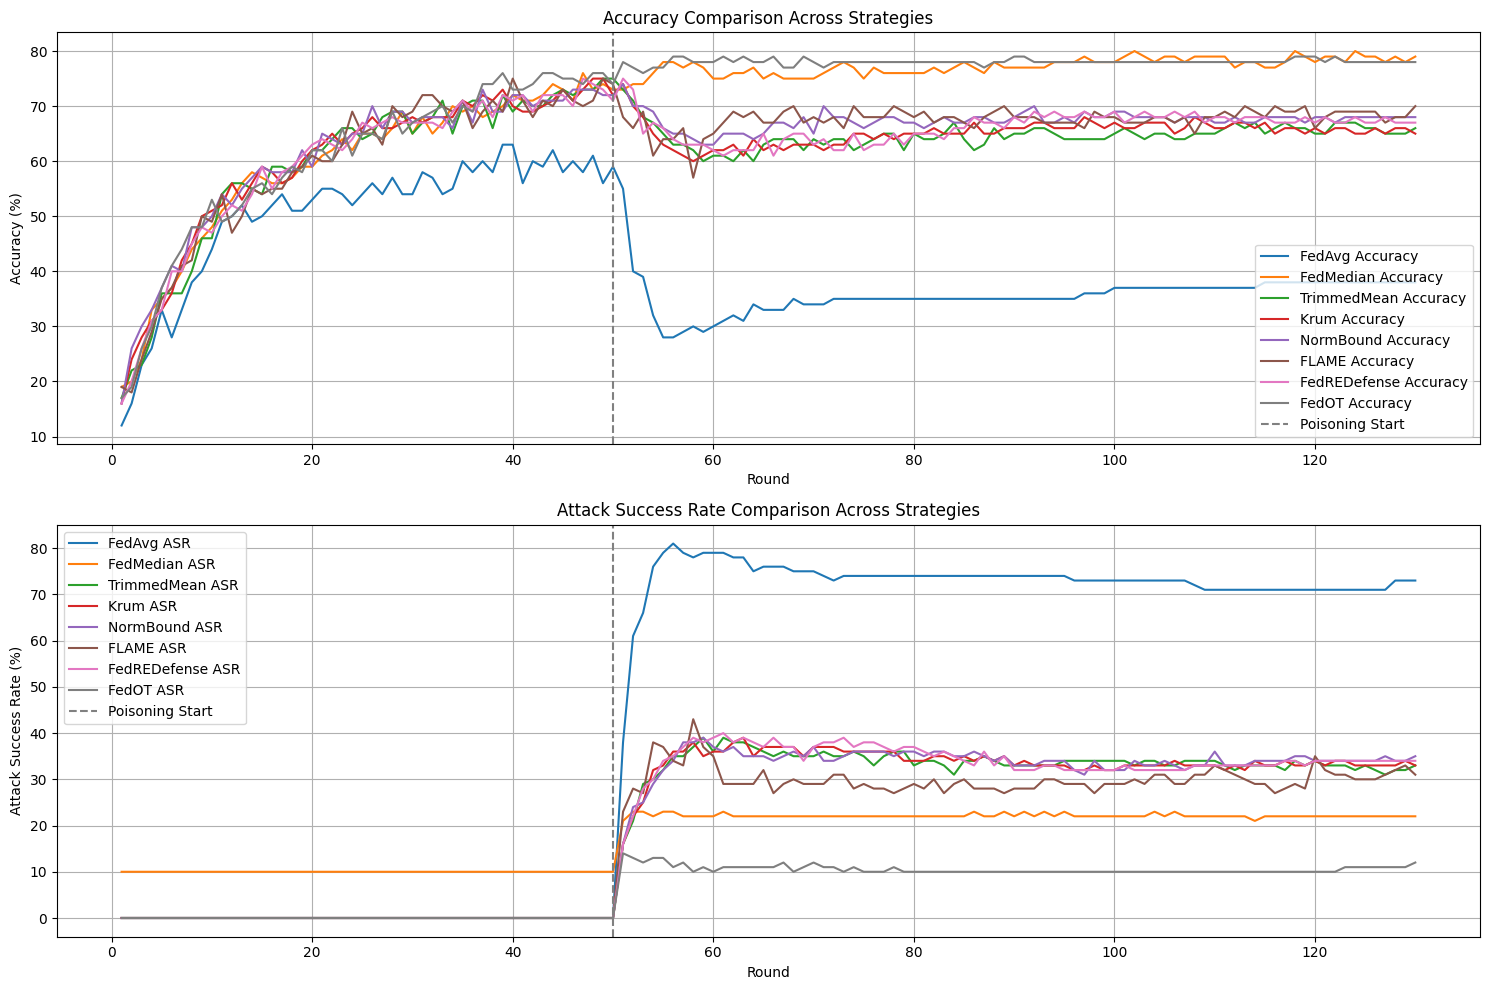

In [91]:
import json

# Load from JSON and plot
with open('strategies_metrics150_0.5_ours2.json', 'r') as f:
    loaded_data = json.loads(f.read().strip())
strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum", "NormBound", "FLAME", "FedREDefense", "FedOT"]
# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies  
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'][:130], loaded_data[strategy]['accuracy'][:130],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    asr_values = loaded_data[strategy]['asr'][:130]
    if strategy == "FedMedian":
        asr_values = [x + 10 for x in asr_values]
    plt.plot(loaded_data[strategy]['rounds'][:130], asr_values,
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('comparison_ours.pdf', bbox_inches='tight')
plt.show()
